<a href="https://colab.research.google.com/github/LuisMig-code/Vai-chover-amanha-/blob/main/Vai_chover_amanh%C3%A3%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vai chover amanhã?

<img src="https://images.pexels.com/photos/125510/pexels-photo-125510.jpeg?auto=compress&cs=tinysrgb&dpr=1" width=700>

Não sei vocês , mas eu constantemente checo o clime, questão de hábito. A todo momento estou olhando a temperatura para o dia todo! Se vai chover mais tarde ou não , com certeza eu sei te dizer! Pensando nisso , imaginei : "Como saber se de fato amanhã vai chover? como os metereologistas fazem esse processo?". Já devo adiantar , não vou trazer uma resposta científica e complexa para essa pergunta , mas um *dataset* que achei na internet pode me ajudar nesse questionamento!

## Vamos pensar!

O Primeiro passo é **entender o que estamos buscando de resultado e posteriormente entender o dados!**


Afinal , o que queremos com esse projeto? Simples: **Construir um modelo de Machine Learning para saber se amanhã vai chover ou não!**

Tendo isso em mente , precisamos entender os nossos dados, o que temos a nossa disposição para responder essa pergunta?

## Nossos dados:

O conjunto de dados (*dataset*) esta disponível no [kaggle](https://www.kaggle.com/) e trás consigo diversas informações climáticas (direção do vento,temperatura máxima e mínima , pressão do ar, etc) de um determinado dia e se choveu ou não no dia seguinte a ele!

Para acessar essa base de dados , clique [aqui](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package).

O primordial para qualquer projeto em *Data Science* é começar importando todas as bibliotecas necessárias para as análises.

In [1]:
# import necessários:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score , classification_report
from imblearn.under_sampling import NearMiss

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Tendo tudo importando , devemos começar lendo nossa base de dados:

In [2]:
path_dados = "https://raw.githubusercontent.com/LuisMig-code/Vai-chover-amanha-/main/data/weatherAUS.csv?raw=true"

In [3]:
df = pd.read_csv(path_dados)

In [4]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Vamos começar identificando quantas linhas de dados temos no nosso *Dataset*

In [5]:
print(f"* {df.shape[0]} linhas")

* 145460 linhas


### Tratando os dados:

O interessante a ressaltar aqui é que neste conjunto de dados temos valores que são numéricos e outros que são categóricos , ou seja , não podemos simplesmente sair removendo qualquer valor vazio que temos aqui, o ideal é pensar beem no que vamos remover do *Dataset*

**Não irei entrar no mérito do significado de cada coluna visto que são muitas , mas sinta-se a vontade para checar por você mesmo o que cada uma das colunas significa clicando [aqui](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package)**

Vamos começar tratando as colunas categóricas, com elas eu poderei sim remover!

In [6]:
lista_colunas_cat = ["Date" , "Location" , "WindGustDir" , "WindDir9am" , "WindDir3pm" , "RainToday" , "RainTomorrow"]

df.dropna(subset=lista_colunas_cat , inplace=True)

Outro fato que eu gostaria de ressaltar é acerca da data. Para nós a data exata não faz diferença , mas o mês pode sim fazer , visto que provavelmente existem meses do anos que chovem mais do que o comum e outros não , por isso , irei transformar a coluna de data para apenas valores numéricos referenciando o mês em questão.

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

df['month'] = df['Date'].dt.month

df.drop("Date",inplace=True,axis=1)

Por último , temos de decidir o que vamos fazer com os valores numéricos. Normalmente você pode remover os que estão faltantes ou atribuir um peso diferente para eles , para nosso caso eu vou simplesmente remover!

Por que não atribuir peso? Simples: **Ao atribuir um peso , para este caso em específico , irei tornar os dados não verídicos!**

In [8]:
df.dropna(inplace=True)

Com os dados tratados , vamos ver quantas linhas de dados temos agora?

In [9]:
print(f"* {df.shape[0]} linhas")

* 56420 linhas


Com os dados tratados , podemos passar agora para uma análise mais visual destes dados!

### Visualização de dados:

Tendo os dados bem estruturados , chegou a hora de visualizar algumas variáveis importantes.

Começarei identificando qualquer desbalanceamento na nossa variável alvo do *dataset*

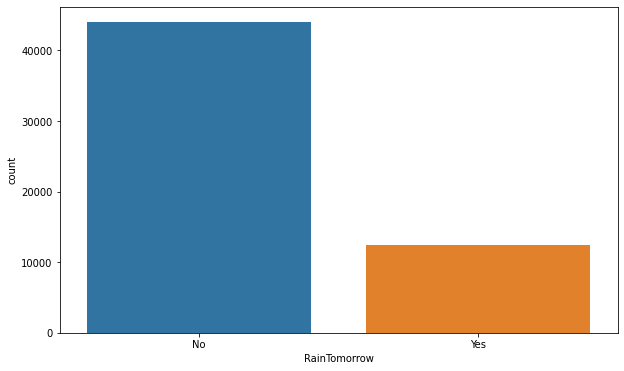

In [10]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x = df["RainTomorrow"])
ax = ax
ax

Já podemos notar que temos um desbalanceamento nas classes. Existem mais dados onde nossa variável alvo(*RainTomorrow*) foi classificada como "No" em comparação aos classificados como "Yes".

Em um outro artigo meu já debati mais sobre esse tema , como resolvê-lo e as consequências dele para um projeto de *DataScience* , caso queira acessar , clique [aqui](https://luis-miguel-code.medium.com/como-lidar-com-classes-desbalanceadas-em-machine-learning-precision-recall-oversampling-e-ce21e3ccb615).

Irei aplicar o Nearmiss nos dados , mas somente na parte de Machine Learning.

Por hora , vamos nos concentrar em entender a correlação das nossas variáveis.

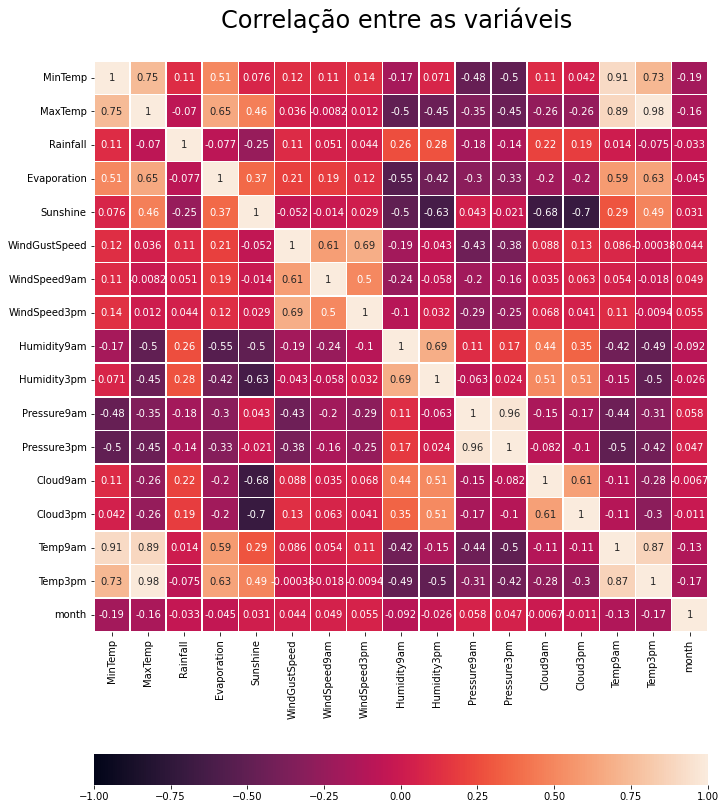

In [11]:
plt.figure(figsize=(11,15))

ax = sns.heatmap(df.corr() , cbar_kws={"orientation": "horizontal"} , annot=True , 
                 vmin=-1.0 , vmax=1.0 , linewidths=.5)
ax.set_title("Correlação entre as variáveis \n" , fontsize=24)
ax=ax

Com esse gráfico podemos identificar a correlação que as variáveis numéricas tem entre sí de forma numérica , onde **+1 significa uma correlação positva , -1 uma correlação engativa e 0 nenhuma correlação!**

## Machine Learning

Antes de tomar qualquer ação , devo lembrar que alguns dos nossos dados (categóricos) são valores do tipo texto , modelos de *Machine Learning* não interpretam textos , apenas número . Logo , o primeiro passo a ser tomado é **transformar esses dados em dados interpretáveis pela máquina**.

In [12]:
colunas_categorias = ["RainToday","RainTomorrow"]

encoder = preprocessing.LabelEncoder()

for coluna in colunas_categorias:
  df[coluna] = encoder.fit_transform(df[coluna])

In [13]:
colunas_get_dummies = ["Location","WindGustDir","WindDir9am","WindDir3pm"]

df = pd.get_dummies(df,columns=colunas_get_dummies)

In [14]:
df.sample(5)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,month,Location_AliceSprings,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Darwin,Location_Hobart,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_NorfolkIsland,Location_Nuriootpa,Location_Perth,Location_PerthAirport,Location_Portland,Location_Sale,Location_Sydney,Location_SydneyAirport,...,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
102861,6.7,19.2,0.0,4.0,12.4,33.0,20.0,13.0,54.0,38.0,1025.3,1022.2,6.0,3.0,12.8,17.8,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
106671,19.1,37.2,0.0,10.8,9.0,39.0,19.0,20.0,16.0,7.0,1015.2,1012.9,6.0,4.0,26.8,36.7,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
80554,9.7,19.3,0.0,0.8,5.0,20.0,4.0,7.0,99.0,50.0,1023.6,1021.9,7.0,6.0,11.9,18.3,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
79787,14.4,29.8,0.0,5.6,10.7,30.0,4.0,19.0,80.0,38.0,1025.3,1021.4,8.0,1.0,15.8,28.7,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
22449,14.9,20.1,0.0,4.6,1.7,48.0,24.0,31.0,79.0,91.0,1020.3,1018.1,7.0,8.0,17.6,15.8,0,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Feito isso , podemos começar a dividir nossos dados em variáveis X (variável explicativa) e variável Y (alvo).

In [15]:
X = df.drop(["RainTomorrow"],axis=1)
y = df.RainTomorrow

Assim , chegou a parte de proporcionalizar nossos dados e tornanr o número de dados iguais para ambas as classificação de *RainTomorrow*.

In [16]:
# instanciando o NearMiss
nm = NearMiss()

# Aplicando o Near Miss aos nossos dados:
valores_X , valores_y = nm.fit_sample(X , y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


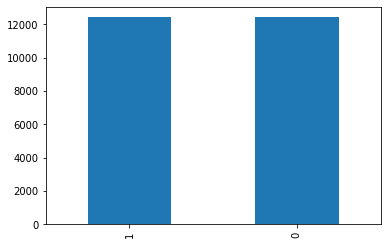

In [17]:
pd.Series(valores_y).value_counts().plot(kind="bar")

Podemos ver agora que ambas tem a mesma quantidade de dados!

A próxima etapa agora é dividir nossos dados em dados de treino e teste:

In [18]:
X_treino , X_teste , y_treino , y_teste = train_test_split(valores_X , valores_y ,shuffle=True,random_state=0,stratify=valores_y)

Com os dados divididos , chegou a hora de criar de fato um modelo de predição:

O modelo que será usado é o XGBoost . Não irei entrar nas minúncias das características dele , no geral , para dados tabulares ele é o que melhor se comporta! Caso tenha interesse em entender mais sobre o funcionamento dele, sugiro o vídeo do [Mário Filho](https://www.instagram.com/mariofilhoml/) , para acessar clique [aqui](https://www.youtube.com/watch?v=fG8H-0rb0mY).

O primeiro passo é *instanciar* o modelo:

In [19]:
cl = XGBClassifier(random_state = 0,
                   learning_rate = 0.05,
                   n_estimators = 100,
                   max_depth=5)

Com o modelo criado , é necessário agora treiná-lo com os dados que separamos anteriormente:

In [21]:
cl.fit(X_treino,y_treino)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Com um modelo já feito e treinado , chegou a hora de fazer as medições da precisão dele. Para isso vamos usar os dados de teste para checar isso:

In [22]:
predicoes = cl.predict(X_teste)
acuracia = round(accuracy_score(y_teste,predicoes) * 100,2)
print(f"{acuracia}% de acurácia")
print(classification_report(y_teste,predicoes))

81.7% de acurácia
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      3107
           1       0.86      0.76      0.81      3107

    accuracy                           0.82      6214
   macro avg       0.82      0.82      0.82      6214
weighted avg       0.82      0.82      0.82      6214



De forma mais geral , tivemos uma precisão do modelo de quase 82% , e uma boa precisão para a classificação de ambas as classe (0 ou 1). Caso queira entender como interpretar estes dados, sugiro acessar [este](https://luis-miguel-code.medium.com/como-lidar-com-classes-desbalanceadas-em-machine-learning-precision-recall-oversampling-e-ce21e3ccb615) meu outro artigo o qual eu explico melhor.

## Conclusões:


Hoje aprendemos como se fazem previsões temporais usando Machine Learning , assim como o uso do algoritmo mais famoso do momento , o XGBoost para fazer classificações! Aplicamos também o conceito de undersampling nos dados a fim de encontrar um melhor resultado para nosso modelo. Por hoje é tudo , agradeço a todos que acessaram este notebook Colab.


Caso tenha interesse em me encontrar em outras redes , pode acessá-las aqui:

  -     [Linktree](https://linktr.ee/iNukss)